# residual line plot

[OK] WSE saved → /usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/TORRENT_WSE.tif


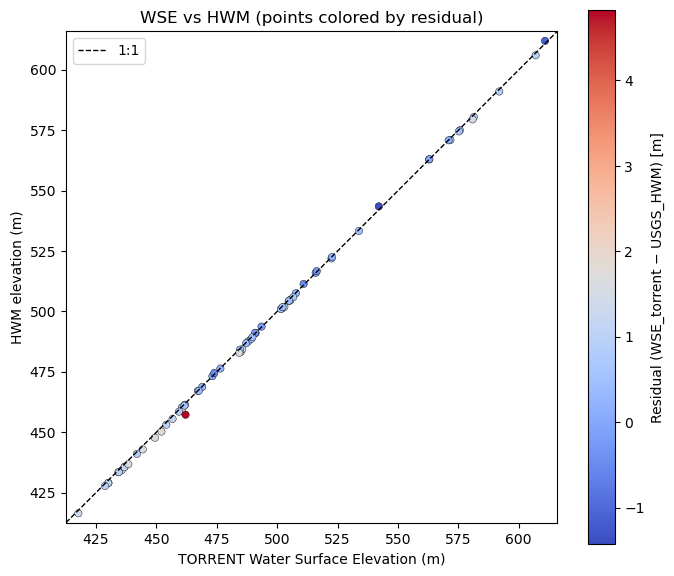

Samples: 67 | MAE=0.804 m | RMSE=1.061 m | Bias=0.671 m


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.warp import reproject, Resampling, transform
import os
os.environ["PROJ_NETWORK"] = "OFF"  # avoid network grid fetch

# =========================
# Paths / column names
# =========================
TORRENT = "/p/lustre1/lazin1/flood/Texas/GuadalupeRiver_2025-07-02_2025-07-06/peak-depth-001.tif"
DEM     = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/Guadalupe_dem_near_kerr.tif"
WSE_OUT = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/TORRENT_WSE.tif"

CSV_HWM = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/HWM/HWM_July2025TX_cleaned.csv"
LAT_COL, LON_COL, ELEV_FT_COL = "latitude_dd", "longitude_dd", "elev_ft"   # adjust if needed
CSV_CRS = "EPSG:4329"  # set to "EPSG:4269" if your CSV coordinates are NAD83

# =========================
# Helper: sample raster at lon/lat points
# =========================
def sample_raster_at_points(raster_path, lons, lats, points_crs="EPSG:4326"):
    """
    Sample raster values at (lon, lat) points. Returns np.array of values (NaN if OOB/NoData).
    """
    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)

    with rasterio.open(raster_path) as src:
        # Reproject input coords to the raster CRS if needed
        if points_crs and src.crs and str(points_crs) != str(src.crs):
            xs, ys = transform(points_crs, src.crs, lons.tolist(), lats.tolist())
        else:
            xs, ys = lons, lats

        band = src.read(1, masked=True)
        vals = np.full(lons.shape, np.nan, dtype=float)

        for i, (x, y) in enumerate(zip(xs, ys)):
            try:
                row, col = src.index(x, y)
                if 0 <= row < src.height and 0 <= col < src.width:
                    v = band[row, col]
                    vals[i] = np.nan if np.ma.is_masked(v) else float(v)
            except Exception:
                pass
    return vals

# =========================
# 1) Build & save WSE (DEM + depth reprojected to DEM grid)
# =========================
with rasterio.open(DEM) as dem_ds, rasterio.open(TORRENT) as dep_ds:
    dem = dem_ds.read(1).astype("float32")
    dst_crs = dem_ds.crs
    dst_transform = dem_ds.transform
    height, width = dem_ds.height, dem_ds.width

    depth = dep_ds.read(1).astype("float32")
    depth[depth == 0] = np.nan
    if dep_ds.nodata is not None:
        depth = np.where(depth == dep_ds.nodata, np.nan, depth)

    depth_on_dem = np.full((height, width), np.nan, dtype="float32")
    reproject(
        source=depth,
        destination=depth_on_dem,
        src_transform=dep_ds.transform,
        src_crs=dep_ds.crs,
        src_nodata=np.nan,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        dst_nodata=np.nan,
        resampling=Resampling.bilinear,
    )

    WSE = np.where(np.isfinite(dem) & np.isfinite(depth_on_dem), dem + depth_on_dem, np.nan).astype("float32")

    profile = dem_ds.profile.copy()
    profile.update(dtype="float32", count=1, nodata=np.nan, compress="deflate", predictor=3)
    with rasterio.open(WSE_OUT, "w", **profile) as dst:
        dst.write(WSE, 1)

print(f"[OK] WSE saved → {WSE_OUT}")

# =========================
# 2) Read & clean CSV; compute meters; build GeoDataFrame
# =========================
df = pd.read_csv(CSV_HWM)

# Ensure required columns exist
for col in (LAT_COL, LON_COL, ELEV_FT_COL):
    if col not in df.columns:
        raise ValueError(f"CSV missing required column: {col}")

# Coerce to numeric and drop non-finite lat/lon
for c in (LAT_COL, LON_COL, ELEV_FT_COL):
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[np.isfinite(df[LAT_COL]) & np.isfinite(df[LON_COL]) & np.isfinite(df[ELEV_FT_COL])]
df = df[df[LAT_COL].between(-90, 90) & df[LON_COL].between(-180, 180)].copy()

# Feet → meters
df["elv_meter"] = df[ELEV_FT_COL] * 0.3048

# GeoDataFrame in CSV_CRS (WGS84 by default)
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df[LON_COL], df[LAT_COL])], crs=CSV_CRS)

# =========================
# 3) Sample elevation_torrent (WSE) at those points
# =========================
elevation_torrent = sample_raster_at_points(WSE_OUT, gdf.geometry.x.values, gdf.geometry.y.values, points_crs=gdf.crs)
gdf["elevation_torrent"] = elevation_torrent

# Keep valid rows (both sides finite)
gdf_valid = gdf[np.isfinite(gdf["elevation_torrent"]) & np.isfinite(gdf["elv_meter"])].copy()
if gdf_valid.empty:
    raise RuntimeError("No valid samples found. Check point CRS/overlap with WSE raster.")

# Residuals
gdf_valid["residual"] = gdf_valid["elevation_torrent"] - gdf_valid["elv_meter"]

# =========================
# 4) Scatter with residual coloring
# =========================
x = gdf_valid["elevation_torrent"].to_numpy()
y = gdf_valid["elv_meter"].to_numpy()
res = gdf_valid["residual"].to_numpy()

fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x, y, c=res, cmap="coolwarm", s=28, edgecolor="k", linewidths=0.3)

# 1:1 line & axes
mn = float(np.nanmin([x.min(), y.min()]))
mx = float(np.nanmax([x.max(), y.max()]))
pad = 0.02 * (mx - mn if mx > mn else 1.0)
ax.plot([mn - pad, mx + pad], [mn - pad, mx + pad], "k--", lw=1, label="1:1")

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Residual (WSE_torrent − USGS_HWM) [m]")

ax.set_xlabel("TORRENT Water Surface Elevation (m)")
ax.set_ylabel("HWM elevation (m)")
ax.set_title("WSE vs HWM (points colored by residual)")
ax.legend(loc="upper left")
ax.set_aspect("equal", adjustable="box")
ax.set_xlim(mn - pad, mx + pad)
ax.set_ylim(mn - pad, mx + pad)

plt.tight_layout()
plt.show()

# Quick stats
mae = float(np.mean(np.abs(res)))
rmse = float(np.sqrt(np.mean(res**2)))
bias = float(np.mean(res))
print(f"Samples: {len(res)} | MAE={mae:.3f} m | RMSE={rmse:.3f} m | Bias={bias:.3f} m")



# residual map

[OK] WSE saved → /usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/TORRENT_WSE.tif
CRS: EPSG:4326
Bounds: [-99.69379519  29.79906353 -98.36630757  30.26335991]


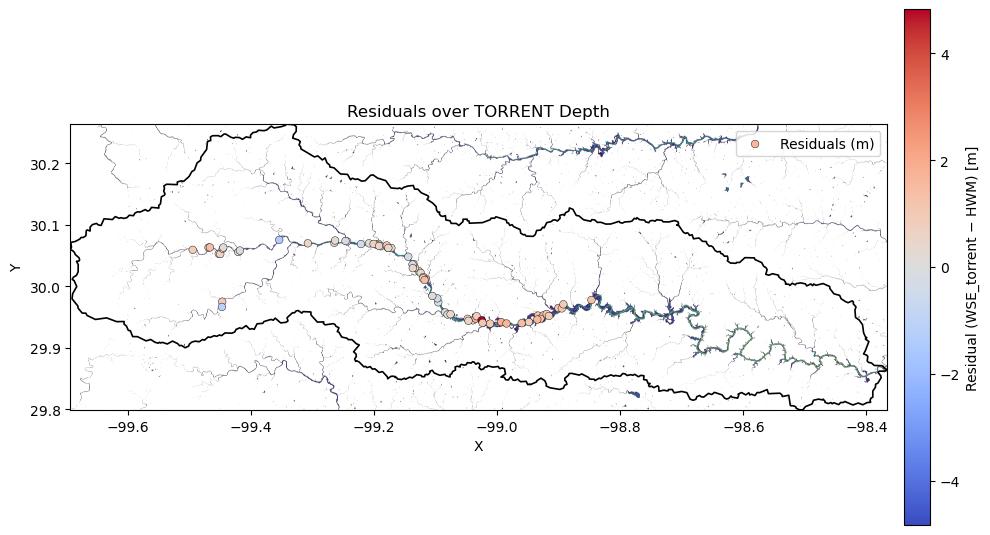

Points plotted: 67 | MAE=0.804 m, RMSE=1.061 m, Bias=0.671 m


In [3]:
import os
os.environ["PROJ_NETWORK"] = "OFF"  # avoid network grid fetches

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, transform
from matplotlib.colors import TwoSlopeNorm
import contextily as ctx

# ---------------- Paths ----------------
TORRENT = "/p/lustre1/lazin1/flood/Texas/GuadalupeRiver_2025-07-02_2025-07-06/peak-depth-001.tif"
DEM     = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/Guadalupe_dem_near_kerr.tif"
WSE_OUT = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/TORRENT_WSE.tif"

CSV_HWM = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/HWM/HWM_July2025TX_cleaned.csv"
LAT_COL, LON_COL, ELEV_FT_COL = "latitude_dd", "longitude_dd", "elev_ft"

# If your CSV long/lat are NAD83, set to EPSG:4269. Use EPSG:4326 if WGS84.
CSV_CRS = "EPSG:4269"

# ---------------- Build (or load) WSE = DEM + TORRENT depth ----------------
# Align TORRENT depth onto DEM grid, add to DEM, and save to WSE_OUT
with rasterio.open(DEM) as dem_ds, rasterio.open(TORRENT) as dep_ds:
    dem = dem_ds.read(1).astype("float32")
    height, width = dem_ds.height, dem_ds.width

    depth = dep_ds.read(1).astype("float32")
    depth[depth == 0] = np.nan
    if dep_ds.nodata is not None:
        depth = np.where(depth == dep_ds.nodata, np.nan, depth)

    depth_on_dem = np.full((height, width), np.nan, dtype="float32")
    reproject(
        source=depth,
        destination=depth_on_dem,
        src_transform=dep_ds.transform,
        src_crs=dep_ds.crs,
        src_nodata=np.nan,
        dst_transform=dem_ds.transform,
        dst_crs=dem_ds.crs,
        dst_nodata=np.nan,
        resampling=Resampling.bilinear,
    )

    WSE = np.where(np.isfinite(dem) & np.isfinite(depth_on_dem), dem + depth_on_dem, np.nan).astype("float32")

    prof = dem_ds.profile.copy()
    prof.update(dtype="float32", count=1, nodata=np.nan, compress="deflate", predictor=3)
    with rasterio.open(WSE_OUT, "w", **prof) as dst:
        dst.write(WSE, 1)
        dst.update_tags(1, vertical_datum="NAVD88", vertical_units="meters",
                        description="Water Surface Elevation = DEM + TORRENT depth")

print(f"[OK] WSE saved → {WSE_OUT}")

# ---------------- Read CSV, make GeoDataFrame, convert feet→meters ----------------
df = pd.read_csv(CSV_HWM).rename(columns=str.strip)
for c in (LAT_COL, LON_COL, ELEV_FT_COL):
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[df[LAT_COL].between(-90, 90) & df[LON_COL].between(-180, 180)].dropna(subset=[LAT_COL, LON_COL, ELEV_FT_COL]).copy()
df["elv_meter"] = df[ELEV_FT_COL] * 0.3048

gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df[LON_COL], df[LAT_COL])], crs=CSV_CRS)

# ---------------- Sample WSE at point locations ----------------
with rasterio.open(WSE_OUT) as wse_ds:
    # reproject points to WSE CRS if needed
    if gdf.crs != wse_ds.crs:
        xs, ys = transform(gdf.crs, wse_ds.crs, gdf.geometry.x.tolist(), gdf.geometry.y.tolist())
    else:
        xs, ys = gdf.geometry.x.values, gdf.geometry.y.values

    wse_band = wse_ds.read(1, masked=True)
    vals = np.full(len(xs), np.nan, dtype="float32")
    for i, (x, y) in enumerate(zip(xs, ys)):
        try:
            r, c = wse_ds.index(x, y)
            if 0 <= r < wse_ds.height and 0 <= c < wse_ds.width:
                v = wse_band[r, c]
                vals[i] = np.nan if np.ma.is_masked(v) else float(v)
        except Exception:
            pass

gdf["elevation_torrent"] = vals
gdf_valid = gdf[np.isfinite(gdf["elevation_torrent"]) & np.isfinite(gdf["elv_meter"])].copy()
gdf_valid["residual"] = gdf_valid["elevation_torrent"] - gdf_valid["elv_meter"]

# ---------------- Plot TORRENT raster + residual scatter ----------------
with rasterio.open(TORRENT) as tor_ds:
    fig, ax = plt.subplots(figsize=(10, 6))

    # background: TORRENT depth
    # robust color scale for the raster
    depth = tor_ds.read(1).astype("float32")
    depth[depth < 0.8] = np.nan
    
    left, bottom, right, top = tor_ds.bounds
    extent = [left, right, bottom, top]
    finite = depth[np.isfinite(depth)]
    vmin = 0.0
    vmax = float(np.percentile(finite, 99)) if finite.size else 1.0
    # show(tor_ds, ax=ax, cmap="viridis", vmin=vmin, vmax=vmax)
    img = ax.imshow(depth, extent=extent, cmap="viridis", vmin=vmin, vmax=vmax, origin="upper")

    # project points to TORRENT CRS before plotting
    if gdf_valid.crs != tor_ds.crs:
        xs, ys = transform(gdf_valid.crs, tor_ds.crs,
                           gdf_valid.geometry.x.tolist(), gdf_valid.geometry.y.tolist())
    else:
        xs, ys = gdf_valid.geometry.x.values, gdf_valid.geometry.y.values

    res = gdf_valid["residual"].to_numpy()

    # symmetric color around zero for residuals
    rmax = np.nanmax(np.abs(res)) if res.size else 1.0
    norm = TwoSlopeNorm(vmin=-rmax, vcenter=0.0, vmax=rmax)

    sc = ax.scatter(xs, ys, c=res, cmap="coolwarm", norm=norm,
                    s=30, edgecolor="k", linewidths=0.3, zorder=10, label="Residuals (m)")

    # Path to your shapefile
    shp_path = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/Guadalupe_River.shp"

    # Read shapefile
    gdf = gpd.read_file(shp_path)

    # Print CRS and bounds for reference
    print("CRS:", gdf.crs)
    print("Bounds:", gdf.total_bounds)

    # Plot
    gdf.plot(ax=ax,edgecolor="black", facecolor="none", linewidth=1.2)
    
    # colorbar for residuals
    cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Residual (WSE_torrent − HWM) [m]")

    ax.set_title("Residuals over TORRENT Depth")
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    # ctx.add_basemap(ax, crs=tor_ds.crs,
    #                 source="https://mt1.google.com/vt/lyrs=t&x={x}&y={y}&z={z}")
    ax.legend(loc="upper right")

    plt.tight_layout()
    # plt.savefig("/path/to/residuals_on_torrent.png", dpi=300)
    plt.show()

# quick stats
res = gdf_valid["residual"].to_numpy()
print(f"Points plotted: {len(res)} | "
      f"MAE={np.mean(np.abs(res)):.3f} m, RMSE={np.sqrt(np.mean(res**2)):.3f} m, Bias={np.mean(res):.3f} m")
